# Interpreting Machine Learning models with SHAP

Interpretability of a model is extremely important in Data Science. The end user of your model usually needs to understand why the model is making its predictions. We often find that as the complexity of the ML model increases, it becomes increasingly hard to interpret and is labelled a black box. In this notebook, we will look at what are Shapley values, and how we can use Shapely Additive Explanations (SHAP) to better understand our model. We will see how SHAP can be used for both global and local interpretability. First, let us see what the difference between the two is.

## 1. Global vs Local interpretability

**Global interpretability**

Global interpretability is trying to comprehend the entire model at once. This requires knowledge of the trained model, knowledge of the algorithm and the data. It is about understanding how the model makes decisions based on a holistic view of its features and each learned component, such as weights, interactions etc., and gives an idea of the distribution of the target outcome based on the features. In practice, this can not be achieved for any model that is slightly complex. For example, even a linear regression with 5 features would be difficulty to visualise since we are not able to visualise in a 5d plane, and whilst the weights provide information on the contribution, there may be interactions that are not captured (such as correlation in the features) just by looking at the weights.

Despite these challenges, it is still important to have a global interpretability of a model using the best measures / plots available. This is commonly seen in things such as feature importance plots for many algorithms (such as based on number of splits in some tree feature importance plots).

**Local interpretability**

Local interpretability is examining how a model predicts for a single input and why. Despite a model being complex, at the individual data point level it is often not as complex. For example, the quality of red wine may depend on many things such as alcohol, citric acid, ph e.g. which interact with each other. However, for a particular wine, there may be a more monotonic relationship between wine quality with alcohol. This can be tested by simulating how the quality for that wine changes with small changes in the alcohol content.

## 2. What is the Shapley Value?

**Definition**

Shapley values can be used to interpret complex models. It is a method from coalitional game theory, and tells us how to fairly distribute the "payout" among the features. It can be defined as:

*The Shapley value of a feature is the average of the marginal contributions across all permutations.*

This can sound confusing and intimidating, and perhaps a simpler definition is:

*Shapley values simply interpret the impact of a feature taking a certain value in comparison to the prediction we would have made if that feature had taken some baseline value.*

**Example**

As an example, suppose we have a model to predict house price with 3 features (bedrooms, location, car park spaces). Given a particular house, we want to know the contribution of each of these features. First we look at the average price of all houses (which we assume to be 500k). Suppose the price of this house is 520k. This means the contribution of the 3 features for this house has resulted in a gain of 20k.

- Average house price = 500k
- House price for this observation = 520k
- Net gain = 520 - 500 = **20k**

The result of the Shapley value contributions for each feature might be:

- bedrooms = 3 --> +40k
- car park = 2 --> +10k
- location = X --> -30k

Net contribution = 40 + 10 - 30 = **20k**.

Note how the net contribution is precisely the gain of 20k over the baseline.

How did we derive the contribution for each of the 3 features? Let us look at how we may derive the contribution of the bedrooms feature. There are 3 main steps:

1. Get all permutations of the features not including bedroom
2. For each permutation, by adding the feature bedroom how much is the net gain affected? This is the marginal contribution of bedroom
3. Take the average of the marginal contributions to derive overall contribution of bedroom

In this case, the permutations are:

- no features
- car park
- location
- car park + location

For each permutation above, we predict with and without bedroom, and the difference is the marginal contribution of bedroom. Finally, we take the average to get the marginal contribution of bedroom.

## 3. Properties of Shapley values and pros and cons

**Desirable Properties**

The Shapley value is the only attribution method that satisfied the properties of **Efficiency, Symmetry, Dummy** and **Additivity**.

- Efficiency - The feature contributions must add up to the difference in the prediction and the average
- Symmetry - The contributions of two features should be the same if they contribute equally to all possible coalitions
- Dummy - A feature that does not change the predicted value - regardless of which coalition of features values it is added to - should have a Shapely value of 0
- Additivity - For games with combined payouts, the Shapely values can be added together (e.g. Random Forest, Shapely value for each tree can be determined then averaged to get overall Shapely value)

**Advantages**

- solid theoretical foundation
- prediction is fairly distributed among all feature values
- allows contrastive explanations (can compare data point to average in a group, rather then entire data)

**Disadvantages**

- significant computing time (although in most implementations, some changes are made to make if fast)
- can be misinterpreted (correlation not causation)
- always uses all features
- does not build a prediction model, so always need access to full data to determine Shapley value for new data point
- inclusion of unrealistic data instances when features are correlated

## 3. SHAP - A Shapley-value-based explanation

Calcuting the exact Shapley values is usually prohibitively long. This has resulted in many different Shapley-value based explanations which make minor changes / assumptions to speed up the process. A Shapley-value-based explanation method tries to approximate Shapley values of a given prediction by examining the effect of removing a feature under all possible combinations of presence or absence of the other features. We will focus on one particular type, namely the SHAP (SHapely Additive exPlanations).

SHAP estimates the model's behaviour on an input with certain features absent by averaging over samples drawn from the data (rather than every single possible value). How this sample is drawn is important, and there are different implementations for how the sample is chosen. The popular ones (implemented in Python as well) are:

- kernel SHAP - works for all models however takes longer
- DeepExplainer SHAP - for deep learning models
- TreeExplainer SHAP - for tree based models (supports sklearn, catboost, light gbm etc.)

Kernel SHAP takes the longest, however is not limited to the type of model.  Tree and DeepExplainer are both optimised to be faster by making smart tweaks to how it is calculated. However note that because of the tweaks they are not identical, so the results from Kernel and Tree SHAP on the same model will be different. The specific differences are out of scope of this notebook.


## 4. Example Implementation in Python

Below we will walk through an example of Tree SHAP. Kernel SHAP could also be used with very similar syntax. In this example we will be working with a dataset which has the quality of various red wines, as well as features that define the red wine. We will first build a XGBoost model, from which we can then apply SHAP to understand contribution of each feature.

### 4.1 Build XGBoost model

We will build a XGBoost model, using train and test split along with grid search 5-fold cross-validation. The specifics of this will not be covered here as this is not the purpose of the notebook, however these step are taken to generate a more robust model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score, max_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score, mean_poisson_deviance, mean_gamma_deviance
import shap

# initialise java script for Shapley
shap.initjs()

We will read in the data set, and split into train and test.

In [2]:
wine_quality_df = pd.read_csv("winequality-red.csv")

In [3]:
X = wine_quality_df.drop(columns='quality')
y = wine_quality_df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We then apply a grid search to determine the best hyper parameters for our model.

In [4]:
xgb_model = XGBRegressor()

parameters = {
    'objective':['reg:squarederror']
    ,'learning_rate':[0.01,0.1,0.5]
    ,'max_depth':[3,5,8]
    ,'min_child_weight':[1,3,5]
    ,'subsample':[0.3,0.5,0.8]
    ,'colsample_bytree':[0.3,0.5,0.8]
    ,'n_estimators':[50,200,500]
    ,'seed':[0]
}

grid_model = GridSearchCV(
    xgb_model
    ,parameters
    ,n_jobs=-1
    ,cv=5
    ,scoring='r2'
    ,verbose=1
    ,refit=True
)

grid_model.fit(X_train, y_train)

xg_best = grid_model.best_estimator_

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3645 out of 3645 | elapsed:  4.6min finished
Series.base is deprecated and will be removed in a future version


We also look at loss metrics to evaluate the model.

In [5]:
def loss_metric_regression(model, X_train, y_train, X_test, y_test):
    '''Determine loss metrics for regression models'''
   
    loss_metric_list = [
        mean_squared_error
        ,explained_variance_score
        ,max_error
        ,mean_absolute_error
        ,mean_squared_log_error
        ,median_absolute_error
        ,r2_score
        ,mean_poisson_deviance
        ,mean_gamma_deviance
    ]

    loss_metric_name_list = [
        'Mean Squared Error:'
        ,'Explained Variance Score:'
        ,'Max Error:'
        ,'Mean Absolute Error:'
        ,'Mean Squared Log Error:'
        ,'Median Absolute Error:'
        ,'R2 Score:'
        ,'Mean Poisson Deviance:'
        ,'Mean Gamma Deviance:'
    ]
   
    loss_metric_log_list = [
        'mean_squared_error'
        ,'explained_variance_score'
        ,'max_error'
        ,'mean_absolute_error'
        ,'mean_squared_log_error'
        ,'median_absolute_error'
        ,'r2_score'
        ,'mean_poisson_deviance'
        ,'mean_gamma_deviance'
    ]

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
   
    print("{0:30} {1:25} {2:25}".format("","Train set error","Test set error"))
    for loss_metric in list(zip(loss_metric_list, loss_metric_name_list)):
        print("{0:30} {1:<25} {2:<25}".format(
            loss_metric[1]
            ,loss_metric[0](y_train, pred_train)
            ,loss_metric[0](y_test, pred_test))
        )

In [6]:
loss_metric_regression(xg_best, X_train, y_train, X_test, y_test)

                               Train set error           Test set error           
Mean Squared Error:            0.07549516767881018       0.3247270745678897       
Explained Variance Score:      0.8901003770464381        0.4335190527316046       
Max Error:                     1.181318759918213         2.4450531005859375       
Mean Absolute Error:           0.20589792159873122       0.4118794992566109       
Mean Squared Log Error:        0.001729200127951959      0.008079337955171987     
Median Absolute Error:         0.15670251846313477       0.31946754455566406      
R2 Score:                      0.8874956130892702        0.4327524320069618       
Mean Poisson Deviance:         0.013356010800428678      0.05932450614599063      
Mean Gamma Deviance:           0.002438711907045997      0.01104917188303143      


### 4.2 Understanding model using SHAP

**Calculate SHAP values**

We are now ready to use TreeExplainer to interpret our model. We first calculate the Shapley values (with assumptions in Tree SHAP) for each data point using the code below.

In [7]:
explainer = shap.TreeExplainer(xg_best)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


The dataframe shows the Shapley values for each feature for the first 5 rows of data.

In [8]:
shap_values_df = pd.DataFrame(shap_values)
shap_values_df.columns = X.columns
shap_values_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.000219,-0.135768,0.010812,0.000139,0.015236,0.017440,0.056090,-0.083100,-0.066583,-0.136699,-0.224615
1,0.010507,-0.304678,-0.041891,0.010436,-0.064273,-0.034671,-0.112058,0.007125,0.049765,0.080146,-0.265042
2,0.008148,-0.161810,0.002405,0.025357,0.094244,0.019327,-0.032293,-0.027284,0.005445,0.125014,-0.254417
3,0.059423,0.294834,-0.010527,0.026587,0.058990,0.005109,-0.023412,-0.065507,0.062786,-0.100875,-0.187272
4,-0.000219,-0.135768,0.010812,0.000139,0.015236,0.017440,0.056090,-0.083100,-0.066583,-0.136699,-0.224615


**Visualising SHAP values for individual predictions**

It is very easy to visualise which features are contributing to an individual prediction. From below, we can see that on average, the wine quality is 5.605, however in this case the wine quality is 4.94. The red features are contributing to a higher wine quality, whereas the blue features are contributing to a lower wine quality, with a net effect of having a lower wine quality.

In this case, the volatile acidity is the most dominant feature which is lowering the wine quality.

In [9]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

The below code also lets us visualise the same information as above, but for many data points at once to see trends as value changes. For example, by setting the horizontal value to 'alcohol' and vertical value to 'model output value', we can see that after about 10.5, alcohol has a strong positive contribution to wine quality.

In [10]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

**SHAP Dependence plots**

We can also look at the partial dependece plots, which show the marginal effect a feature has on the predicted wine quality. Here we can see that as alcohol increases, there is a relatively linear effect on the target variable. By default, the plot also shows the variable most correlated to it, which is 'volatile acidity' in this case, where we can see there is frequent interaction between the two.

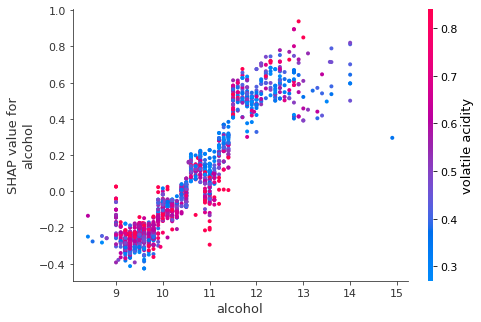

In [11]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("alcohol", shap_values, X)

If we look at density instead, we can see there is a negative relatinoship that is not quite as linear.

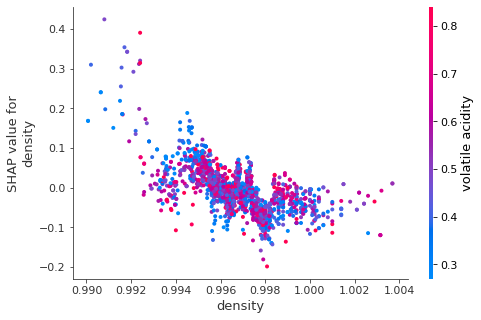

In [12]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("density", shap_values, X)

**Detailed Variable Importance plot - Global interpretability**

The below plot shows which features are the most significant in descending order. Each dot represents a data point, and the horizontal location shows what value it took in that prediction. The colour shows how much contribution of importance that value had for that data point (so we tend to see more reds in the extremes, especially for important features).

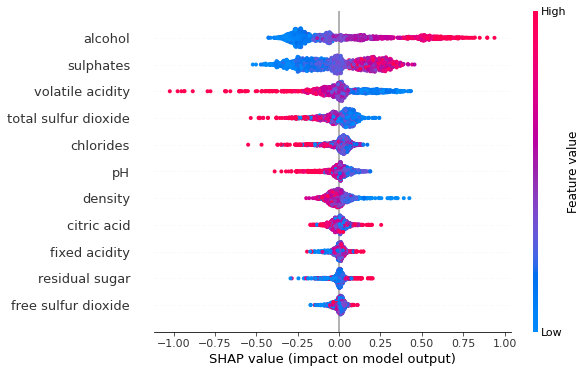

In [13]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

**Simplified Variable importance plot - Global interpretability**

A more simplified plot of the above can also be plotted, showing the feature importance in descending order.

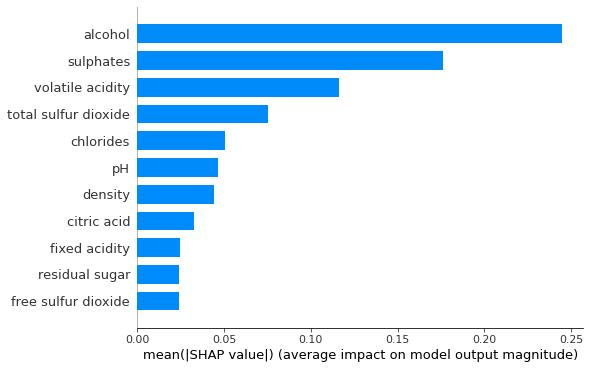

In [14]:
shap.summary_plot(shap_values, X, plot_type="bar")

The following code further highlights each bar in red for positive correlation and blue for negative correlation to the target (code from Dr. Dataman).

In [15]:
def ABS_SHAP(df_shap, df):
    
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

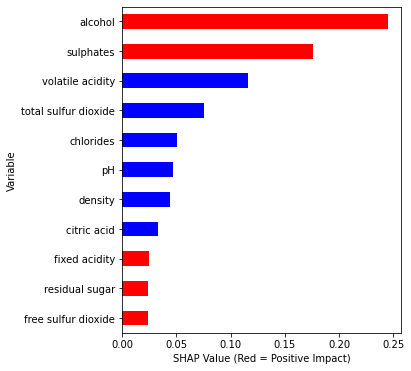

In [16]:
ABS_SHAP(shap_values, X) 